# **COMP 2211 Exploring Artificial Intelligence** #
## Lab 2 Naive Bayes Classifier ##


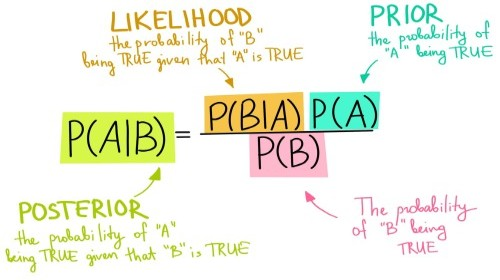

## Before We Begin ##

Run the code in the following two code cells to "mount" the Google drive directory.

## Mount Google Drive
Download and save a copy of the Lab2 Notebook and Excel files (*heart_disease_train_dataset.csv*, *heart_disease_test_dataset.csv*) to your Google Drive, ensuring that all three files are in the same location.

In [1]:
from google.colab import drive
drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%ls /content/drive

MyDrive/


Modify the pathway of the *%cd* shell command according to the location in your Google Drive where you have saved the Notebook and Excel files. Double check the output of the *%ls* shell command to ensure that you are in the correct working directory; it should display the filenames of *lab2.ipynb*, *heart_disease_train_dataset.csv*, and *heart_disease_test_dataset.csv*.

In [ ]:
%cd "/content/drive/MyDrive/COMP2211/Lab2"
%ls

/content/drive/MyDrive/COMP2211/Lab2
heart_disease_test_dataset.csv  heart_disease_train_dataset.csv


# Dataset Description
*heart_disease_train_dataset.csv* contains 250 training samples, consisting of 6 features (resting_blood_pressure, serum_cholesterol, diabetes, left_ventricular_hypertrophy, ST_slope_anomaly, myocardial_defect) and 1 target label (heart_disease). The first row is the header row containing the column names, for a total of 251 rows and 7 columns.

Below is the list of column names, their possible values, and the information that they represent:

Column Name                            | Variable Type | Remarks 
---------------------------------------|---------------|--------
resting_blood_pressure                 | Categorical   | 0 = normal ; 1 = elevated ; 2 = hypertension
serum_cholesterol                      | Categorical   | 0 = normal ; 1 = mild-risk ; 2 = high-risk
diabetes                               | Binary        | 0 = no ; 1 = yes
left_ventricular_hypertrophy           | Binary        | 0 = no ; 1 = yes
ST_slope_anomaly                       | Binary        | 0 = no ; 1 = yes
myocardial_defect                      | Binary        | 0 = no ; 1 = yes
heart_disease                          | Binary        | 0 = no ; 1 = yes

\
*heart_disease_test_dataset.csv* contains 50 test samples, consisting of the same 6 features (resting_blood_pressure, serum_cholesterol, diabetes, left_ventricular_hypertrophy, ST_slope_anomaly, myocardial_defect) and 1 target label (heart_disease). The first row is also the header row containing the column names, for a total of 51 rows and 7 columns. Your task is to predict the 50 target labels with *Naive Bayes Classifier*, with conditional probabilities calculated from the 250 training samples, and then check your accuracy against the actual target labels.


## Load Datasets
Load the train and test datasets from Google Drive into NumPy using *loadtxt()*.
To read *.csv* files, we specify comma as the delimiter, and also skip the header row.

In [ ]:
import numpy as np
# delimiter: The string used to separate values. As ',' is used as delimiter in csv, we specify delimiter as ','
# skiprows: Skip the first skiprows lines; default: 0. As we want to skip the header row, we specify skiprows as 1 
train = np.loadtxt("heart_disease_train_dataset.csv", delimiter=',', skiprows=1)
test = np.loadtxt("heart_disease_test_dataset.csv", delimiter=',', skiprows=1)

In [ ]:
print(train.shape)
train

(250, 7)


array([[0., 2., 0., ..., 0., 0., 1.],
       [2., 2., 0., ..., 0., 1., 1.],
       [0., 2., 0., ..., 1., 0., 1.],
       ...,
       [2., 2., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.],
       [2., 2., 1., ..., 1., 0., 0.]])

# Naive Bayes Classifier

## Task 1: Relative Frequencies
First of all, calculative the relative frequencies of each feature given the target label (Likelihoods, i.e. $P(feature|label)$), as well as the frequencies of each target label (Prior Probability, i.e. $P(label)$). Since our goal is only Classification, we don't need to worry about the denominator (Marginal Probability). 

Optional: Fill-in the table below to help keep track of our calculations.

|               | Resting Blood Pressure |     |    | / | Serum Cholesterol |     |    | / | Diabetes |     |    | / | Left Ventricular Hypertrophy |     |    | / | ST Slope Anomaly |     |    | / | Myocardial Defect |     |    | / | Heart Disease |     |    |
|---------------|------------------------|-----|----|---|-------------------|-----|----|---|----------|-----|----|---|------------------------------|-----|----|---|------------------|-----|----|---|-------------------|-----|----|---|---------------|-----|----|
| Heart Disease |                        | Yes | No | / |                   | Yes | No | / |          | Yes | No | / |                              | Yes | No | / |                  | Yes | No | / |                   | Yes | No | / |               | Yes | No |
|               | Hypertension           |     |    | / | High-Risk         |     |    | / | Yes      |     |    | / | Yes                          |     |    | / | Yes              |     |    | / | Yes               |     |    | / | -             |     |    |
|               | Elevated               |     |    | / | Mild-Risk         |     |    | / | No       |     |    | / | No                           |     |    | / | No               |     |    | / | No                |     |    | / | -             | -   | -  |
|               | Normal                 |     |    | / | Normal            |     |    | / | -        | -   | -  | / | -                            | -   | -  | / | -                | -   | -  | / | -                 | -   | -  | / | -             | -   | -  |


In [ ]:
# The given code below calculates the Prior Probabilities of Heart Disease.
# Modify the code to also calculate the Likelihoods for all the remaining features.

train_features = train[:, :-1] # All except the last column.
train_labels = train[:, -1]    # Only the last column.

num_heart_disease_yes = 0 # Count of heart_disease = yes
num_heart_disease_no = 0  # Count of heart_disease = no

# N: #data pieces (250)
# feat_N: #features (6)
N, feat_N = train_features.shape

# 3 dimenstions
# # 1. Each feature can take 2 or 3 possible values. Use size 3 for this dimension.
# #    The features with only 2 possible values should use the first two rows, and the last row all set to 0
# # 2. The label feature (heart disease) has two possible values (Yes or No)
# # 3. There are feat_N = 6 features in total.
# Ultimately, we want features_likelihoods[i, j, k] to be P(the k-th feature has value i | the label has value j)
features_likelihoods = np.zeros((3, 2, feat_N))


for label_val in range(2):
  # train_mask is a boolean array which will be used to index
  # Note that it is 1D because we derive it from *train_labels*, not *train_features*
  # In numpy, we often call such a boolean array used to index another array as a "mask"
  train_mask = train_labels == label_val
  # Refer to Boolean Array Index in Lab1_Review.ipynb
  # But here we only use 1D mask to select the 1st dimension of train_features, and keep the 2nd dimention intact
  # Eventually, we only select the *rows* (each row is a data piece) whose label value (heart disease?) equals label_val, for label_val in N/Y.
  # train_portion has a shape (some value < 250, 6)
  train_portion = train_features[train_mask, :]
  for feat_val in range(3):
    # We first find all the cells in train_portion whose value is feat_val (again, 0 or 1 or 2)
    # (train_portion == feat_val) is a 2D bolean array where such cells are True
    # Taking mean assumes all True's as 1 and False's as 0. We take mean along the first (0th) dimension.
    # Hence, the RHS becomes a 1D array of shape (6,), wehre the k-th cell represens the *percentage* of True's of the k-th feature
    #   among all data pieces in train_portion.
    # In other words, RHS[k] == P(the k-th feature has value feat_val | the label has value label_val)
    features_likelihoods[feat_val, label_val, :] = (train_portion == feat_val).mean(axis=0)


# Sanity check
# for any feature k, Σ_{all possible feature value i} P(feathre k has value i | label value is 0) == 1
assert np.all(features_likelihoods[:, 0, :].sum(axis=0) == 1)
# for any feature k, Σ_{all possible feature value i} P(feathre k has value i | label value is 1) == 1
assert np.all(features_likelihoods[:, 1, :].sum(axis=0) == 1)
# Only the first features may have value==2, the remaining features should never have value==2 (only 0 or 1)
assert not np.any(train_features[:, 2:] == 2)
# Consequently, P(the remaining features have value 2 | any label value) == 0
assert np.all(features_likelihoods[2, :, 2:] == 0)
# Set those 0's to NaN, so hopefully there are warnings or strange values if we ever touch those cells afterwards ;)
features_likelihoods[2, :, 2:] = np.nan


# TODO: Can you also replace the for-loop here using Boolean indexing (masks) and numpy functions?
for row in range(train_features.shape[0]):
  if train_labels[row] == 1:
    num_heart_disease_yes += 1

  else:
    num_heart_disease_no += 1

heart_disease_yes = num_heart_disease_yes/train.shape[0] # P(heart_disease = yes)
heart_disease_no = num_heart_disease_no/train.shape[0]   # P(heart_disease = no)

## Task 2: Prediction
Now that we have the Prior Probabilities of Heart Disease and the Likelihoods of each feature, the next step is to use *Naive Bayes Classifer* to predict the target labels of *heart_disease_test_dataset.csv*.
To avoid floating-point underflow, we will use the **sum-of-log-probabilities** version of the *Naive Bayes* formula - the predicted label has the highest sum-of-log-probabilities score.

$B_{NB} = argmax_{B_i}(logP(B_{i}) + ∑_{n=1}^d logP(e_n|B_i))$

Note: It doesn't matter which log base we use because of the change-of-base formula: $log_ax = \frac{log_bx}{log_ba}$

In [ ]:
# The given code below sums the log-prior-probability of Heart Disease.
# Modify the code to also sum the log-likelihoods for all the remaining features, according to the specific test case.

test_features = test[:, :-1] # All except the last column.
test_labels = test[:, -1]    # Only the last column.
predict_labels = np.zeros_like(test_labels)       # Create a numpy array of zeros with the same shape as test_labels. 

log_heart_disease_yes = np.log(heart_disease_yes) # log_e of P(heart_disease = yes)
log_heart_disease_no = np.log(heart_disease_no)   # log_e of P(heart_disease = no)

# Take log element-wise
# Again, log_features_likelihoods[i, j, k] = log P(the k-th feature has value i | the label has value j)
log_features_likelihoods = np.log(features_likelihoods)


# TODO: Can you replace this for-loop entirely with numpy operations?
for row in range(test_features.shape[0]):
  predict_yes = log_heart_disease_yes # log_e of P(heart_disease = yes)
  predict_no = log_heart_disease_no   # log_e of P(heart_disease = no)
  
  # Take the row's features (6,) from the test_features dataset
  feature_values = test_features[row]
  # numpy load values as double type by default. We want to convert them to int for the next line...
  feature_values = feature_values.astype(int)

  # Refer to Integer Array Index in Lab1_Review.ipynb
  # Here, the int array indexing "zips" feature_values & np.arange(feat_N) into 2D coordinations (f_v[0], 0)...(f_v[5], 5)
  # And we use these 6 coordinations to take "the logP where the i-th feature == feature_values[i]" (Given label==1 of course)
  to_add = log_features_likelihoods[feature_values, 1, np.arange(feat_N)] # shape (6,)
  assert to_add.shape == (feat_N,) and not np.any(np.isnan(to_add)) # Sanity check
  predict_yes += to_add.sum() # add the summation to predict_yes

  # Same given label==0
  to_add = log_features_likelihoods[feature_values, 0, np.arange(feat_N)]
  assert to_add.shape == (feat_N,) and not np.any(np.isnan(to_add))
  predict_no += to_add.sum()

  # Assign 0 or 1 to predict_labels
  predict_labels[row] = int(predict_yes > predict_no)

## Test Accuracy
Now we compare our predictions versus the actual target labels of *heart_disease_test_dataset.csv*. At the very least, we should achieve significantly higher than 50% accuracy, which is the baseline for guessing all 0s or all 1s. 

In [ ]:
num_match = 0
for i in range(predict_labels.shape[0]):
  if predict_labels[i] == test_labels[i]:
    num_match += 1
accuracy_score = num_match/predict_labels.shape[0]

print(accuracy_score)
print(predict_labels)
print(test_labels)

0.74
[1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 0.]
[1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0.
 0. 0.]


# Unmount Google Drive

In [ ]:
drive.flush_and_unmount()